# LTEM Image Simulation Example
A few examples showing how to simulate LTEM images from a given magnetization. 
  
Authors: Arthur McCray, CD Phatak
V1.0, ANL, May 2020

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import numpy as np
import sys 
sys.path.append("../PyTIE/")
from TIE_helper import *
from sim_helper import *
from TIE_reconstruct import TIE, SITIE

## First a couple examples creating single layer skyrmion magnetization structures
You can click and drag to turn the show3D figures. 

In [ ]:
dim = 64
Bloch_x2, Bloch_y2, Bloch_z2 = Lillihook(dim, Q = 1, gamma=3*np.pi/2)
show_3D(Bloch_x2, Bloch_y2, Bloch_z2, show_all = True, l=2, a = 50)

In [ ]:
anti_x, anti_y, anti_z = Lillihook(dim, rad=dim//4, Q = -1)
show_3D(anti_x, anti_y, anti_z, show_all = False, l=2, a = 50)
show_2D(anti_x, anti_y, l=10, a = 50)

## Calculating the phase shift from a Bloch vortex with the Mansuripur algorithm  
This can only be applied to 2D magnetizations. For more details seee [this paper by Mansuripur](https://doi.org/10.1063/1.348682).   
It can be applied easily to island structures using the shape argument which takes a 2D binary array.  
std_mansPhi is for a a basic example with fixed materials parameters, but for most work one should call mansPhi directly. 

<IPython.core.display.Javascript object>


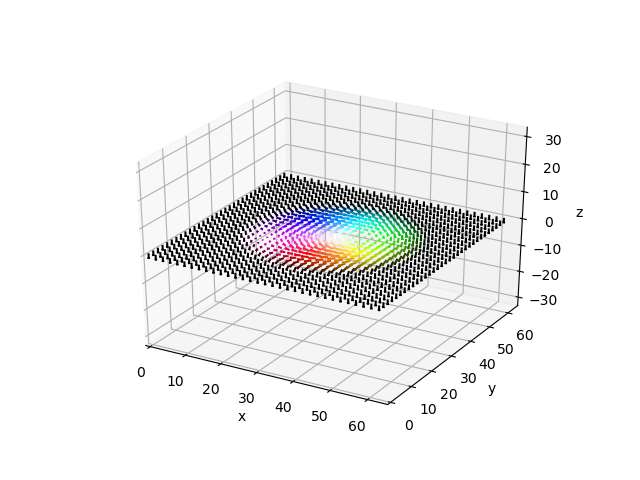

<IPython.core.display.Javascript object>


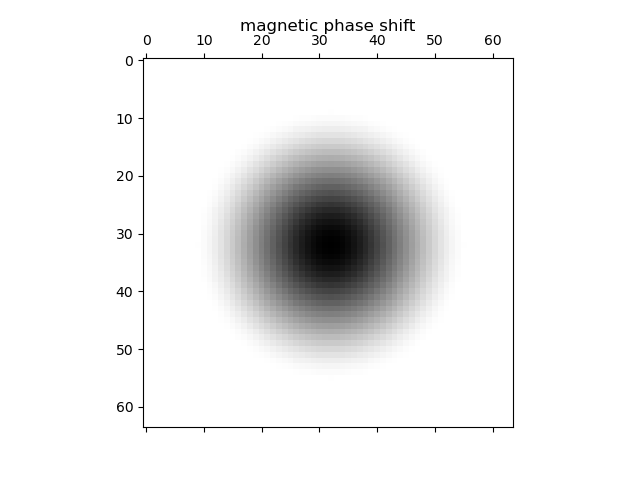

In [3]:
dim = 64
del_px = 10 # nm/pixel
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)
show_3D(Bloch_x, Bloch_y, Bloch_z, show_all = True, l=2, a = 50)

# Apply mansuripur algorithm with some standard materials parameters. 
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, Bloch_z, del_px = del_px)
show_im(mphi, title="magnetic phase shift")

### Simulating LTEM images from the phase shift

In [ ]:
pscope = Microscope(E=200e3,Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)


In [ ]:
# Simulate LTEM images
defval = 50_000
Tphi, im_ov, im_in, im_un = sim_images(mphi, ephi, 
                                       del_px = del_px, 
                                       def_val = defval)
show_sims(Tphi, im_ov, im_in, im_un)

## Getting magnetic and electrostatic phase shift with the linear superposition method  
This method works with 3D magnetization structures but is slower. 

In [ ]:
dim = 64
del_px = 10 # nm/pix
b0 = 1e4 #Gauss default 1e4
phi0 = 2.07e7 #Gauss*nm^2 
cb = b0/phi0*del_px**2 #1/px^2
pre_B = 2*np.pi*cb
ephi_L, mphi_L = linsupPhi(mx=Bloch_x.reshape(dim,dim,1),
                           my=Bloch_y.reshape(dim,dim,1),
                           mz=Bloch_z.reshape(dim,dim,1), 
                           Dshp=np.ones(Bloch_z.reshape(dim,dim,1).shape), 
                           pre_B=pre_B)

In [ ]:
# Simulate LTEM images
defval = 50_000
Tphi, im_ov, im_in, im_un = sim_images(mphi_L, ephi_L, 
                                       del_px = del_px, 
                                       def_val = defval)
show_sims(Tphi, im_ov, im_in, im_un)

# Full example simulating and reconstructing images from a given magnetization

In [ ]:
# slightly larger image this time, using Mansuripur algorithm for speed
dim = 512
del_px = 500/dim

Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True)
ephi, mphi = std_mansPhi(Bloch_x, Bloch_y, Bloch_z, del_px = del_px)

defval = 50_000
Tphi, im_ov, im_in, im_un = sim_images(mphi, ephi, 
                                       del_px = del_px, 
                                       def_val = defval)

### Reconstructing with full TIE  
Uniformly thin film, so no need for a flip stack. 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie = TIE_params(dm3stack=[im_un, im_in, im_ov], defvals=[defval], flip=False)
ptie.make_mask()
ptie.scale = del_px

i = 0 
dataname = f'Example_Bloch' 
sym = False
qc = False
save = False

results = TIE(i, ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

### Single Image TIE (SITIE) Reconstruction 
Example showing how this magnetization can be reconsutructed from a single image.  
This can be applied to experimental images that are uniformly flat, thin, and with only magnetic contrast.  
For more information see [this paper by Chess et. al](https://doi.org/10.1016/j.ultramic.2017.02.004). 

In [ ]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
ptie_SITIE = TIE_params(im_ov, [], defval)
ptie_SITIE.scale = del_px

dataname = 'Example_SITIE_Bloch' 
sym = False
qc = False
save = False

results = SITIE(ptie_SITIE, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save)

#### This can also be done with the original ptie, selecting image with an index from the dm3stack. 

In [ ]:
results = SITIE(ptie, pscope, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save,
                     i=0, # for i=1 will try to reconstruct the infocus image and won't work. 
                     flipstack = False) # True -> reconstruct with flipped image. Result will be flipped too. 

--- End Notebook ---